In [1]:
!pip install xgboost
!pip install datasets
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from datasets import load_dataset
from sklearn.multiclass import OneVsRestClassifier  # Необходимо импортировать
from sklearn.preprocessing import MultiLabelBinarizer
import re

## EDA

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.25k [00:00<?, ?B/s]

(…)-00000-of-00001-46692d7e0c0147a4.parquet:   0%|          | 0.00/6.10M [00:00<?, ?B/s]

(…)-00000-of-00001-9e6cdf9c1f2a20a4.parquet:   0%|          | 0.00/767k [00:00<?, ?B/s]

(…)-00000-of-00001-0acb4be83ca6567e.parquet:   0%|          | 0.00/761k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

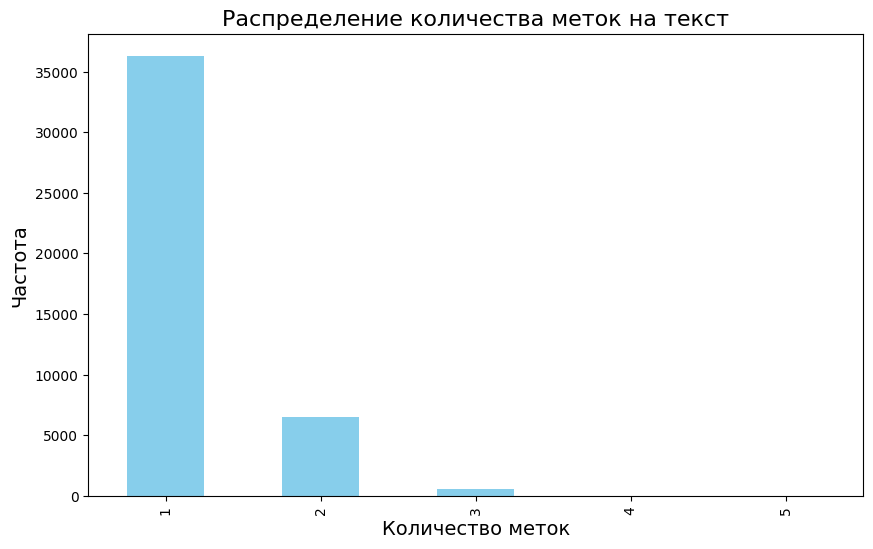

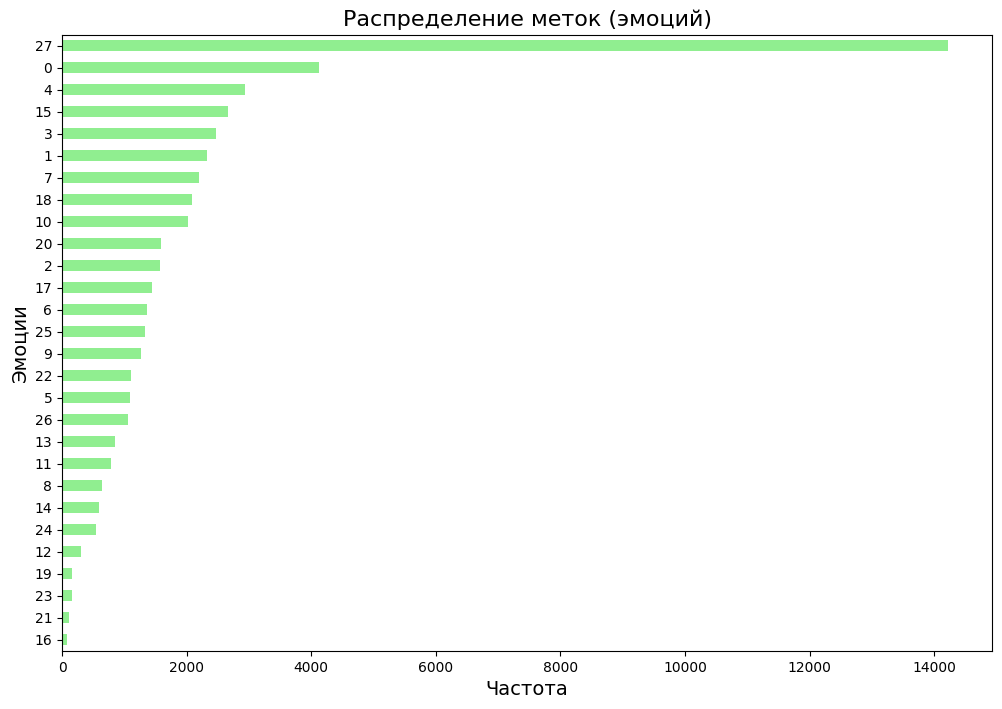

In [3]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from datasets import load_dataset

# Загрузка данных
dataset = load_dataset("seara/ru_go_emotions", "simplified")

# Преобразование в pandas DataFrame
train_data = dataset['train'].to_pandas()

# Преобразуем метки (labels) в отдельные столбцы
mlb = MultiLabelBinarizer()
label_binarized = pd.DataFrame(mlb.fit_transform(train_data['labels']),
                               columns=mlb.classes_,
                               index=train_data.index)

# Добавляем развернутые метки к основному DataFrame
train_data = pd.concat([train_data, label_binarized], axis=1)

# Создаем столбец `label_count` для подсчета количества меток на текст
train_data['label_count'] = train_data[mlb.classes_].sum(axis=1)

# Визуализация распределения количества меток
plt.figure(figsize=(10, 6))
train_data['label_count'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Распределение количества меток на текст', fontsize=16)
plt.xlabel('Количество меток', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.show()

# Визуализация распределения каждой метки
label_counts = train_data[mlb.classes_].sum()
plt.figure(figsize=(12, 8))
label_counts.sort_values().plot(kind='barh', color='lightgreen')
plt.title('Распределение меток (эмоций)', fontsize=16)
plt.xlabel('Частота', fontsize=14)
plt.ylabel('Эмоции', fontsize=14)
plt.show()


## Preprocessing

In [148]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split

# Очистка текстов
def preprocess_text(text):
    """
    Очищает текст от ссылок, символов и приводит к нижнему регистру.
    Args:
        text (str): Исходный текст.
    Returns:
        str: Очищенный текст.
    """
    text = re.sub(r'http\S+', '', text)  # Удаление ссылок
    text = re.sub(r'[^\w\s]', '', text)  # Удаление спецсимволов
    return text.lower()  # Приведение к нижнему регистру

# Определяем столбцы меток
y_columns = train_data.columns[3:]

y_columns = y_columns.drop("id")

# Удалим строки с NaN в метках
train_data_cleaned = train_data.dropna(subset=y_columns)

# Убедимся, что после удаления NaN в метках осталось достаточно данных
if len(train_data_cleaned) == 0:
    raise ValueError("После удаления строк с NaN в метках не осталось данных для обучения.")

# Разделение данных
X = train_data_cleaned['text']  # Тексты
y = train_data_cleaned[y_columns]  # Метки


# Проверка, что данные есть для разделения
if len(X) == 0 or len(y) == 0:
    raise ValueError("После очистки данных нет доступных текстов или меток для разделения.")

# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Выводим размеры выборок для проверки
print(f"Размер обучающей выборки (X_train): {len(X_train)}")
print(f"Размер тестовой выборки (X_test): {len(X_test)}")


Размер обучающей выборки (X_train): 34728
Размер тестовой выборки (X_test): 8682


In [149]:
# Проверка количества текста после очистки
train_data['text_length'] = train_data['text'].apply(len)
print(f"Минимальная длина текста: {train_data['text_length'].min()}")
print(f"Средняя длина текста: {train_data['text_length'].mean()}")
print(f"Максимальная длина текста: {train_data['text_length'].max()}")


Минимальная длина текста: 2
Средняя длина текста: 68.40087537433772
Максимальная длина текста: 703


In [153]:
print(type(X_train))
print(type(y_train))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


## Baseline

In [ ]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

# Преобразование массивов NumPy в списки
y_train = [label.tolist() for label in y_train]
y_test = [label.tolist() for label in y_test]

# Преобразование текстов в Bag-of-Words
vectorizer_bow = CountVectorizer(max_features=5000, min_df=2)
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

# Подготовка меток с использованием MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_train_binarized = mlb.fit_transform(y_train)
y_test_binarized = mlb.transform(y_test)

# Обертываем LogisticRegression в OneVsRestClassifier для многозадачной классификации
multi_target_lr = OneVsRestClassifier(LogisticRegression())

# Обучаем модель
multi_target_lr.fit(X_train_bow, y_train_binarized)

# Предсказания
baseline_predictions = multi_target_lr.predict(X_test_bow)

# Оценка качества
print("Baseline: Логистическая регрессия (BoW)")
for i, emotion in enumerate(mlb.classes_):
    print(f'Эмоция: {emotion}')
    print(classification_report(y_test_binarized[:, i], baseline_predictions[:, i]))


# Визуализация confusion matrix для первой эмоции (пример)
confusion_mtx = multilabel_confusion_matrix(y_test_binarized, baseline_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx[0], annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for {mlb.classes_[0]}')  # Используем mlb.classes_ для доступа к именам меток
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Experiment 1. TF-IDF + XGBoost

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
# Преобразование текстов в TF-IDF
vectorizer_tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

# Подготовка меток с использованием MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_train_binarized = mlb.fit_transform(y_train)
y_test_binarized = mlb.transform(y_test)

# Обучение модели XGBoost с использованием MultiOutputClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
multi_target_xgb = MultiOutputClassifier(xgb_model)
multi_target_xgb.fit(X_train_tfidf, y_train_binarized)

# Оценка качества XGBoost
xgb_predictions = multi_target_xgb.predict(X_test_tfidf)
print("Эксперимент 1: TF-IDF + XGBoost")
for i, emotion in enumerate(mlb.classes_):
    print(f'Эмоция: {emotion}')
    print(classification_report(y_test_binarized[:, i], xgb_predictions[:, i]))

# Вычисление и вывод точности модели
accuracy = accuracy_score(y_test_binarized, xgb_predictions)
print(f'Общая точность модели: {accuracy:.2f}')

## Experiment 2. Transformers - RuBERT

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras import layers, models

# Токенизация
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_tokens = tokenizer(
    list(X_train),
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

test_tokens = tokenizer(
    list(X_test),
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

# Подготовка меток
y_train = y_train['labels'].str.split(',').tolist()

mlb = MultiLabelBinarizer()
y_train_binarized = mlb.fit_transform(y_train)  # Преобразование меток в бинарный формат
y_test_binarized = mlb.transform(y_test)

# Проверка форм меток
print("Форма y_train_binarized:", y_train_binarized.shape)  # Ожидается (количество примеров, количество классов)
print("Форма y_test_binarized:", y_test_binarized.shape)  # Ожидается (количество примеров, количество классов)

# Создание модели
def create_model():
    input_ids = layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    bert_output = bert_model(input_ids, attention_mask=attention_mask)

    # Используем [CLS] токен для классификации
    cls_output = bert_output.last_hidden_state[:, 0, :]

    # Полносвязный слой для классификации
    output = layers.Dense(len(mlb.classes_), activation='sigmoid')(cls_output)

    model = models.Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_model()

# Обучение модели
history = model.fit(
    [train_tokens['input_ids'], train_tokens['attention_mask']],
    y_train_binarized,
    validation_split=0.1,
    epochs=3,
    batch_size=16
)

# Оценка модели
loss, accuracy = model.evaluate([test_tokens['input_ids'], test_tokens['attention_mask']], y_test_binarized)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Применение модели для предсказания
predictions = model.predict([test_tokens['input_ids'], test_tokens['attention_mask']])
predicted_labels = mlb.inverse_transform(predictions > 0.5)  # Порог 0.5 для бинарной классификации

# Пример вывода предсказанных меток
for i in range(5):
    print(f'Text: {X_test[i]}, Predicted Labels: {predicted_labels[i]}')


## Оценка качества, анализ ошибок

In [ ]:
# Матрица ошибок для каждой модели
print("Матрица ошибок: Baseline")
conf_matrix = multilabel_confusion_matrix(y_test, baseline_predictions)
for i, matrix in enumerate(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt="d")
    plt.title(f'Baseline Confusion Matrix for {y.columns[i]}')
    plt.show()

print("Матрица ошибок: XGBoost")
conf_matrix = multilabel_confusion_matrix(y_test, xgb_predictions)
for i, matrix in enumerate(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt="d")
    plt.title(f'XGBoost Confusion Matrix for {y.columns[i]}')
    plt.show()

print("Матрица ошибок: RuBERT")
conf_matrix = multilabel_confusion_matrix(y_test, rubert_predictions)
for i, matrix in enumerate(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt="d")
    plt.title(f'RuBERT Confusion Matrix for {y.columns[i]}')
    plt.show()


## Выводы

По итогу, как и ожидалось, самый сложный с точки зрения архитектуры подход, а именно трансформер, показал самые лучшие результаты. XGBoost также превзошел baseline. В целом все 3 подхода достойно справились с такой сложной задачей